In [226]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [227]:
# Global config variables
sequence_length = 10 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4 #size of the hidden unit of a RNN cell
learning_rate = 0.1

The Basic RNN model:

$S_t = tanh ( W . [X_t, S_{t-1}] + b_s)$

$O_t = \sigma (U . S_t + b_o)$

where

$X_t \in R^{n}$ is the input

$S_t \in R^{h}$ is the internal (memory) state

$O_t \in R^{m}$ is the output

$W \in W^{h \times (n + h)}$

$U \in W^{m \times h}$


## Generate sample time series data

In [228]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-3] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

def gen_batch(raw_data, batch_size, sequence_length):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into sequence_length for truncated backprop
    epoch_size = batch_partition_length // sequence_length
    for i in range(epoch_size):
        x = data_x[:, i * sequence_length:(i + 1) * sequence_length]
        y = data_y[:, i * sequence_length:(i + 1) * sequence_length]
        yield (x, y)

def gen_epochs(n, sequence_length):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, sequence_length)

## Constructing RNN

In [229]:
x = tf.placeholder(tf.int32, [batch_size, sequence_length], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, sequence_length], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
Inputs
"""
rnn_inputs = tf.one_hot(x, num_classes)

"""
RNN
"""

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

"""
Predictions, loss, training step
"""

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))

logits = tf.reshape(tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b,
                    [batch_size, sequence_length, num_classes])
predictions = tf.nn.softmax(logits)

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [230]:
"""
Train the network
"""
def train_network(num_epochs, sequence_length, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, sequence_length)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print "EPOCH {}".format(idx)
            for step, (X, Y) in enumerate(epoch):
                rnn_outputs_, rnn_inputs_, logits_, predictions_, training_loss_, training_state, _ = sess.run([rnn_outputs,rnn_inputs, logits,
                                                                            predictions,
                                                                           total_loss,
                                                              final_state,
                                                              train_step],
                                                             feed_dict={x:X, y:Y, init_state:training_state})
                
                training_loss += training_loss_
                training_losses.append(training_loss_)
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print "Average loss at step {} for the last 100 steps: {}".format(step, training_loss/100)
                        
                        print "with logits_={}, predictions_={}, training_state={}, X={}, Y={} and rnn_inputs={} and rnn_outputs={}".format( \
                                                                                                         logits_.shape, \
                                                                                                         predictions_.shape, \
                                                                                                         training_state.shape, \
                                                                                                         X.shape, \
                                                                                                                   Y.shape, \
                                                                                                                            rnn_inputs_.shape,
                                                                                                                                           rnn_outputs_.shape)
                        
                        print rnn_outputs_[0]
                        #print tf.reshape(rnn_outputs_, [-1, state_size])
                        print rnn_inputs_[0]
                        #print Y[0]
                        #print X[0]
                        
                    training_loss = 0

    return training_losses, rnn_outputs

EPOCH 0
Average loss at step 100 for the last 100 steps: 0.668837966919
with logits_=(200, 10, 2), predictions_=(200, 10, 2), training_state=(200, 4), X=(200, 10), Y=(200, 10) and rnn_inputs=(200, 10, 2) and rnn_outputs=(200, 10, 4)
[[-0.68214297  0.18028188  0.83097148 -0.52902544]
 [-0.21863183 -0.25613251  0.42533121 -0.76614547]
 [-0.18928026 -0.05800383 -0.06939553 -0.3821156 ]
 [-0.33573541  0.33306256 -0.21569587 -0.48532093]
 [-0.32462204  0.5903312   0.04197022 -0.58653641]
 [-0.36017233  0.54334152  0.37121275 -0.71721548]
 [-0.31659931  0.33242807  0.49074826 -0.73676002]
 [-0.28950649  0.15133333  0.40507713 -0.68751478]
 [-0.45016006  0.23995771  0.70654863  0.34325102]
 [-0.54688168 -0.34830466  0.28196591 -0.90074575]]
[[ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]]
Average loss at step 200 for the last 100 steps: 0.63440336287
with logits_=(200, 10, 2), predictions_=(200, 10, 2), training_state=(200, 4), X=(

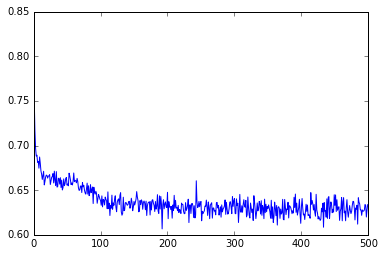

In [231]:
training_losses, final_outputs = train_network(1,sequence_length)
plt.plot(training_losses)

In [238]:
#tf.reset_default_graph()
sess = tf.Session()

In [240]:
final_outputs

<tf.Tensor 'rnn/transpose:0' shape=(200, 10, 4) dtype=float32>

In [234]:
final_outputs

<tf.Tensor 'rnn/transpose:0' shape=(200, 10, 4) dtype=float32>

In [235]:
final_outputs[0]

<tf.Tensor 'strided_slice:0' shape=(10, 4) dtype=float32>

In [263]:
sess.run(tf.reshape(c, [-1, 4])).shape

(20, 4)

In [260]:
c = tf.constant(n)

In [276]:
sess.run(c)

array([[[-0.30207458, -0.2144828 ,  0.2922962 , -0.89958346],
        [ 0.0972557 ,  0.07555988,  0.36663383,  0.56228131],
        [-0.7123701 , -0.40369281,  0.54165143, -0.03810227],
        [ 0.13328263, -0.51643115, -0.31935287, -0.57866144],
        [-0.11718311,  0.43250108, -0.66273999,  0.06660277],
        [-0.49192104,  0.64779162, -0.25703973, -0.60531485],
        [ 0.02542285,  0.6555444 ,  0.05067557, -0.69738293],
        [-0.1285769 ,  0.62170649,  0.13922277, -0.72837681],
        [-0.22947234,  0.47304034,  0.70757604,  0.05872756],
        [-0.25740081, -0.23760922,  0.28760326, -0.87550682]],

       [[-0.30207458, -0.2144828 ,  0.2922962 , -0.89958346],
        [ 0.0972557 ,  0.07555988,  0.36663383,  0.56228131],
        [-0.7123701 , -0.40369281,  0.54165143, -0.03810227],
        [ 0.13328263, -0.51643115, -0.31935287, -0.57866144],
        [-0.11718311,  0.43250108, -0.66273999,  0.06660277],
        [-0.49192104,  0.64779162, -0.25703973, -0.60531485],
      

In [250]:
d = [[-0.30207458,-0.2144828,0.2922962,-0.89958346]
,[0.0972557,0.07555988,0.36663383,0.56228131]
,[-0.7123701,-0.40369281,0.54165143,-0.03810227]
,[0.13328263,-0.51643115,-0.31935287,-0.57866144]
,[-0.11718311,0.43250108,-0.66273999,0.06660277]
,[-0.49192104,0.64779162,-0.25703973,-0.60531485]
,[0.02542285,0.6555444,0.05067557,-0.69738293]
,[-0.1285769,0.62170649,0.13922277,-0.72837681]
,[-0.22947234,0.47304034,0.70757604,0.05872756]
,[-0.25740081,-0.23760922,0.28760326,-0.87550682]]

In [274]:
w = tf.constant([[1.0, 0.0],[0.0, 0.0],[0.0, 0.0],[0.0, 1.0]])
sess.run(w).shape

(4, 2)

In [279]:
b = tf.constant([1.0, 0.0])
sess.run(b)

array([ 1.,  0.], dtype=float32)

In [286]:
y_ = [[1, 0]
,[1, 0]
,[1, 0]
,[1, 0]
,[1, 0]
,[1, 0]
,[1, 0]
,[1, 0]
,[1, 0]
,[1, 0]]
y = tf.constant(y_)
sess.run(y)

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int32)

In [300]:
logits = tf.reshape(tf.matmul(tf.reshape(c, [-1, 4]), w) + b,
                        [2, 10, 2])

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)

In [301]:
sess.run(logits).shape

(2, 10, 2)

In [288]:
sess.run(losses)

array([[ 1.78182852,  0.46101606],
       [ 0.86921769,  0.16595042],
       [ 1.18231606,  0.28400707],
       [ 1.88710284,  0.18393439],
       [ 1.11108613,  0.1808821 ],
       [ 1.78182852,  0.46101606],
       [ 0.86921769,  0.16595042],
       [ 1.18231606,  0.28400707],
       [ 1.88710284,  0.18393439],
       [ 1.11108613,  0.1808821 ]], dtype=float32)

In [289]:
sess.run(total_loss)

0.81073409

In [293]:
logits = tf.matmul(tf.reshape(c, [-1, 4]), w) + b

In [304]:
sess.run(logits).shape

(2, 10, 2)

In [306]:
y_flat = tf.reshape(y,[-1,2])
sess.run(y).shape

(10, 2)

In [305]:
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)